In [1]:
from __future__ import print_function
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import torch
import torch.nn.functional as F
import numpy as np

### Set up the visible GPU

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


### Load the datasets

In [3]:
# load the training images and the semantic segmentation image (mask image)
train = '/home/xiaoyu/data_semantics/training/train/image/'
train_mask = '/home/xiaoyu/data_semantics/training/train/mask_rgb/'

validation = '/home/xiaoyu/data_semantics/training/validation/image'
validation_mask = '/home/xiaoyu/data_semantics/training/validation/mask_rgb'

trainimage = os.listdir(train)
trainmask = os.listdir(train_mask)

print("Training images numbers for different folder of training images: "+str(len(trainimage)))
print("Training mask Images numbers:"+str(len(trainmask)))
image_ex = trainimage[3]
print(image_ex)

Training images numbers for different folder of training images: 160
Training mask Images numbers:160
000035_10.png


### Observe the image data

In [13]:
print("The image size is:" + str(io.imread(os.path.join(train, image_ex)).shape))
print("The mask size is:" + str(io.imread(os.path.join(train_mask, image_ex)).shape))
print('The data type of image is: ' + str(io.imread(os.path.join(train,image_ex)).dtype))
print('The data type of mask is: ' + str(io.imread(os.path.join(train_mask,image_ex)).dtype))
print('The type of image is: ' + str(type(io.imread(os.path.join(train,image_ex)))))

The image size is:(375, 1242, 3)
The mask size is:(375, 1242, 3)
The data type of image is: uint8
The data type of mask is: uint8
The data type of image is: <class 'numpy.ndarray'>


### Data visualization

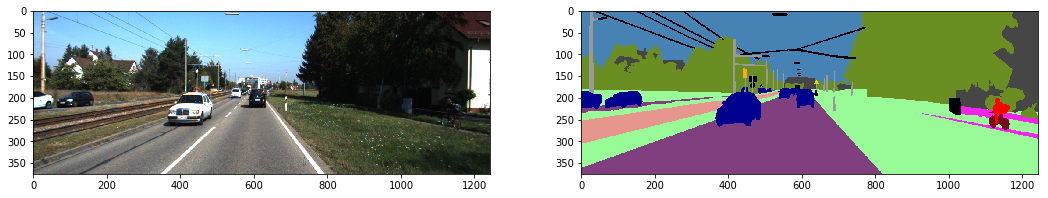

In [15]:
def show_semantic(image, semantic):
    """
    Show images with semantic segmentation
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The traing image semantic segmentation
    """

    plt.subplot(1,2,1)
    plt.imshow(image, aspect='auto')
    plt.subplot(1,2,2)
    plt.imshow(semantic, aspect='auto')
    plt.show()
    
# test the function
plt.figure(figsize=(18, 3))
show_semantic(io.imread(os.path.join(train,image_ex)), 
              io.imread(os.path.join(train_mask,image_ex)))

## Preprocessing of the images
### Traindataset class definition

In [17]:
class TrainDataset(Dataset):
    """Training dataset with mask image on gray scale/RGB"""
    def __init__(self, train_dir, semantic_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.train_dir = train_dir
        self.transform = transform
        self.semantic_dir = semantic_dir
#         Need to consider the mapping:
#         self.mapping = {
#             0: (128, 128, 128),    # Sky
#             1: (128, 0, 0),        # Building
#             2: (128, 64, 128),     # Road
#             3: (0, 0, 192),        # Sidewalk
#             4: (64, 64, 128),      # Fence
#             5: (128, 128, 0),      # Vegetation
#             6: (192, 192, 128),    # Pole
#             7: (64, 0, 128),       # Car
#             8: (192, 128, 128),    # Sign
#             9: (64, 64, 0),        # Pedestrian
#             10: (0, 128, 192),     # Cyclist
#             11: (0, 0, 0)          # Void
#         }
        
    def __len__(self):
        return len(os.listdir(self.train_dir))
    
#     def mask_to_class(self, mask):
#         for k in self.mapping:
#             mask[mask==k] = self.mapping[k]
#         return mask
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.train_dir, os.listdir(self.train_dir)[idx])
        semantic_name = os.path.join(self.semantic_dir, os.listdir(self.semantic_dir)[idx])
        image = io.imread(img_name)
        semantic = io.imread(semantic_name)
        sample = {'image':image, 'semantic':semantic}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (375, 1242, 3) (375, 1242, 3)


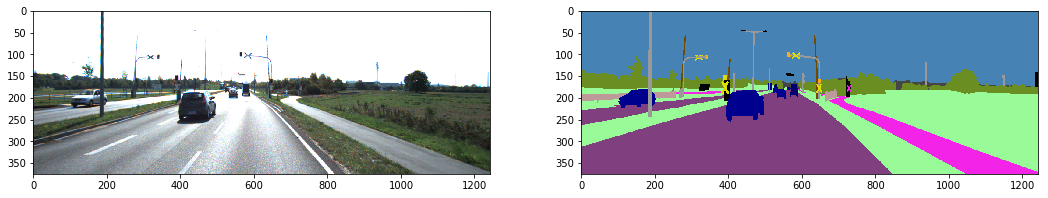

1 (375, 1242, 3) (375, 1242, 3)


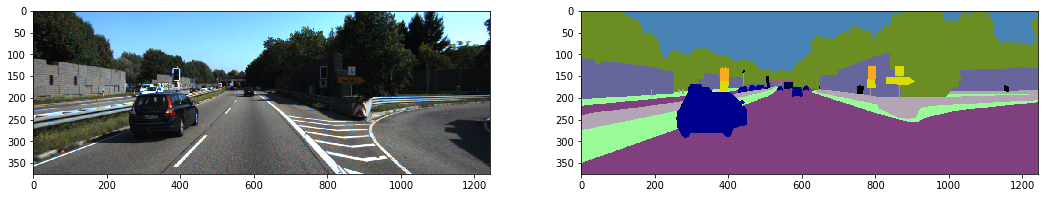

2 (375, 1242, 3) (375, 1242, 3)


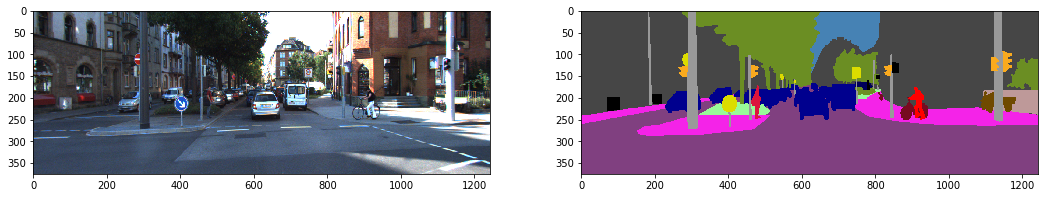

In [18]:
# test the traindataset class without transforms
train_data = TrainDataset(train_dir=train, semantic_dir =train_mask)

for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample['image'].shape, sample['semantic'].shape)
    plt.figure(figsize=(18, 3))
    show_semantic(sample['image'],sample['semantic'])
    
    if i == 2:  
        break

In [19]:
# #Data procesing (mean subtraction and normalization)
# for i in range(len(train_data)):
#     sample = train_data[i]
#     mean = np.mean(sample['image'])
#     mean_semantic = np.mean(sample['semantic'])
#     sample['image']=sample['image'].astype(int)-mean   #mean subtraction
#     sample['image']=sample['image']/np.std(sample['image'],axis=0) #normalization
    
#     sample['semantic']=sample['semantic'].astype(int)-mean_semantic  #mean subtraction
#     sample['semantic']=sample['semantic']/np.std(sample['semantic'],axis=0) #normalization
    
#     print(sample['image'])
   
#     plt.figure(figsize=(18, 3))
#     show_semantic(sample['image'],sample['semantic'])
    
#     if i == 2:  
#         break

In [20]:
class ToTensor(object):
    """Convert ndarrays in sample (both the original image 
    and the semantic image to Tensors"""
    
    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']
        
        #swap color axis because
        #numpy image: H x W x C
        #torch image: C x H x W
        image = image.transpose((2, 0, 1))
        semantic = semantic.transpose((2,0,1))
        return {'image': torch.from_numpy(image),
                'semantic': torch.from_numpy(semantic)}

In [21]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, semantic = sample['image'], sample['semantic']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        semantic = transform.resize(semantic, (new_h, new_w))

        return {'image': img, 'semantic': semantic}
   

In [22]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        semantic = semantic[top: top + new_h, left: left + new_w]

        return {'image': image, 'semantic': semantic}

The original image:


<Figure size 432x288 with 0 Axes>

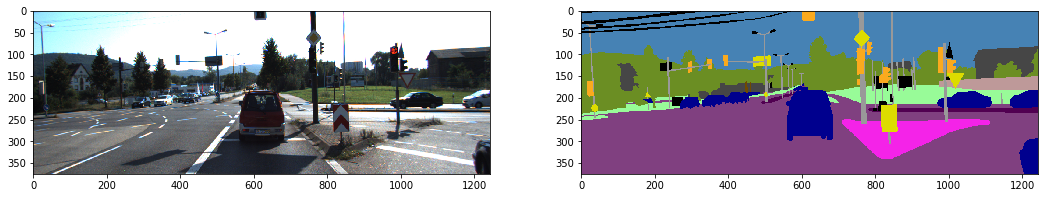

The cropped image:


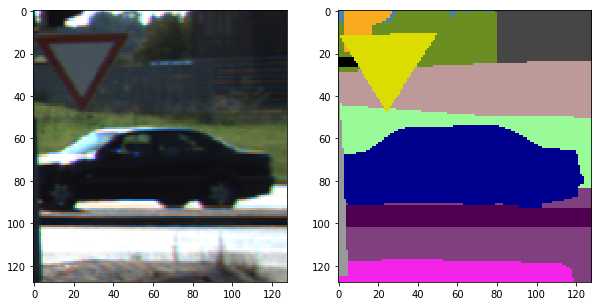

The rescaled image:


/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


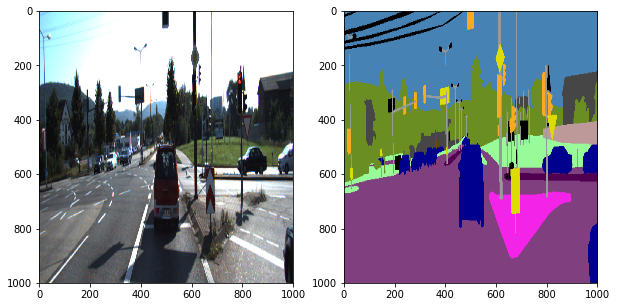

The composed transformed image:


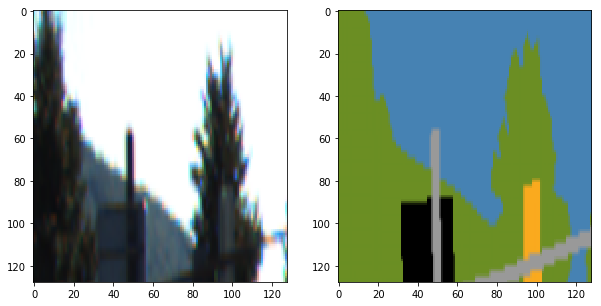

In [23]:
# test of the tress preprocessing of the image functions
scale = Rescale((1000,1000))
crop = RandomCrop(128)
composed = transforms.Compose([Rescale((1000,1000)),RandomCrop(128)])

fig = plt.figure()
sample = train_data[30]

print("The original image:")
plt.figure(figsize=(18, 3))
show_semantic(**sample)

print("The cropped image:")
croped_sample = crop(sample)
plt.figure(figsize=(10, 5))
show_semantic(**croped_sample)

print("The rescaled image:")
rescaled_sample = scale(sample)
plt.figure(figsize=(10,5))
show_semantic(**rescaled_sample)

print("The composed transformed image:")
composed_sample = composed(sample)
plt.figure(figsize=(10, 5))
show_semantic(**composed_sample)

### Make several transformed datasets, which are subsets of the datasets

In [24]:
# the composed transform
composed = transforms.Compose([RandomCrop(256), ToTensor()])
validation_dataset = TrainDataset(train_dir = validation, semantic_dir = validation_mask, transform = composed)
# 3 random cropped dataset
transformed_dataset_A = TrainDataset(train_dir=train, semantic_dir =train_mask, transform = composed)
transformed_dataset_B = TrainDataset(train_dir=train, semantic_dir =train_mask, transform = composed) 
transformed_dataset_C = TrainDataset(train_dir=train, semantic_dir =train_mask, transform = composed) 

In [25]:
# Test the transformed dataset, visualize of the size of the transformed dataset.
for i in range(len(transformed_dataset_A)):
    sample = transformed_dataset_A[i]
    
    print(i, sample['image'].type(torch.FloatTensor).dtype, sample['semantic'].dtype)
    
    if i == 3:
        break

print("Transformed_dataset is : " + str(type(transformed_dataset_A)))

0 torch.float32 torch.uint8
1 torch.float32 torch.uint8
2 torch.float32 torch.uint8
3 torch.float32 torch.uint8
Transformed_dataset is : <class '__main__.TrainDataset'>


### Dataloader class is used for: 
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.
* ```torch.utils.data.DataLoader``` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [27]:
validation_loader = DataLoader(validation_dataset, batch_size =4, shuffle = False, num_workers =4)
dataloader = DataLoader(transformed_dataset_A, batch_size=4, shuffle = False, num_workers = 4)

### Make a dataloader of two different transformed dataset

In [28]:
train_loader = DataLoader(transformed_dataset_A+transformed_dataset_B+transformed_dataset_C,
                          batch_size=4, shuffle=True,
                          num_workers=4)

In [29]:
print(len(train_loader))
print(len(validation_loader))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch)
    print(sample_batched['image'].size())
    if i_batch ==0:
        break

120
10
0
torch.Size([4, 3, 256, 256])


In [30]:
# Helper function to show a batch
def show_semantic_batch(sample_batched):
    """Show original images and semantic images for a batch of samples"""
    images_batch, semantic_batch = \
            sample_batched['image'], sample_batched['semantic']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    grid_semantic = utils.make_grid(semantic_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.pause(0.5)
    plt.imshow(grid_semantic.numpy().transpose((1,2,0)))
 

0 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.uint8
1 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.uint8
2 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.uint8
3 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.uint8


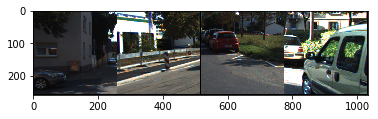

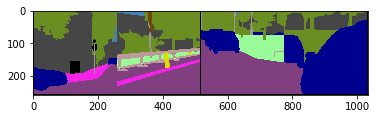

In [31]:
for i_batch, (inputs, target) in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['semantic'].size())
    print(sample_batched['image'].dtype)
    #Observe the 4th batch and stop
    if i_batch == 3:
        plt.figure()
        show_semantic_batch(sample_batched)
        break

### Define the Unet

In [32]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2
    Args:
        in_ch: number of channels of the input
        out_ch: number of channels of the output
        inputsize (N, C_in, H, W) 
        outputsize (N, C_out, H_out, W_out)
        where N is the batch size, C is the number of channels
        kernel =3, stride =1, padding =0
        after the double_conv, the image size is decreased by 4 on each dimention
    '''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        x = self.conv(x)    
        return x

double_conv(
  (conv): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
  )
)
torch.Size([3, 3])
The first conv's weight is: torch.Size([1, 1, 3, 3])
The output size is: torch.Size([2, 1, 572, 572])


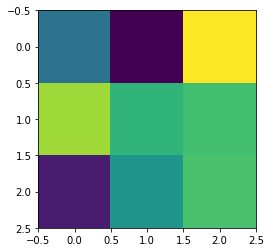

In [33]:
# test the double_conv
double_convnet = double_conv(1,1)
print(double_convnet)
input = torch.randn(2,1,572,572)
output = double_convnet(input)
double_convparams = list(double_convnet.parameters())
first_w = double_convparams[0].detach().squeeze()
print(first_w.size())
plt.imshow(first_w)
print("The first conv's weight is: "+str(double_convparams[0].size()))
print("The output size is: "+str(output.size()))

In [34]:
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [35]:
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )
    def forward(self, x):
        x = self.mpconv(x)
        return x

In [36]:
class up(nn.Module):
    """The algorithms available for upsampling are nearest neighbor and linear,
    bilinear and trilinear for 3D, 4D and 5D input Tensor, respectively."""
    
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


In [37]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [38]:
class UNet(nn.Module):
    """
    Args:
        input channel(int)
        output channel(int)
    """
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)

#### Unet parameters

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

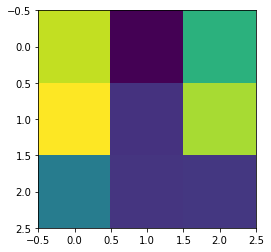

torch.Size([3, 3])


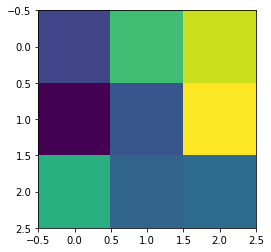

torch.Size([3, 3])


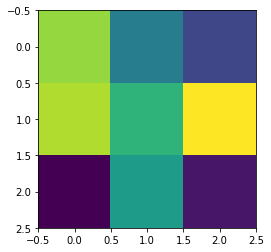

In [39]:
unet = UNet(3,3)
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)

#visualization of the weight
for m in range(64):
    for n in range(3):
        first_weight = unet_params[0].detach().squeeze()[m,n,:,:]
        print(first_weight.size())
        plt.imshow(first_weight)
        plt.pause(1)
    if m ==0:
        break


### Send the weights of the networks to the GPU 

In [40]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [41]:
torch.cuda.device_count()

1

In [42]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [43]:
unet = unet.to(device)

In [44]:
print(unet_params[0].dtype)

torch.float32


### Test the network

In [45]:
inputs = torch.randn(1, 3, 128, 128).to(device)
print(inputs.dtype)
outputs = unet(inputs)
print(outputs.shape)
print(outputs.dtype)
print(outputs)

torch.float32
torch.Size([1, 3, 128, 128])
torch.float32
tensor([[[[ 0.4659,  0.4548,  0.4884,  ...,  0.5139,  0.4779,  0.4527],
          [ 0.4282,  0.4677,  0.5058,  ...,  0.5059,  0.4817,  0.4571],
          [ 0.4880,  0.5066,  0.5055,  ...,  0.4608,  0.5704,  0.4596],
          ...,
          [ 0.4433,  0.4693,  0.4324,  ...,  0.5126,  0.4732,  0.4788],
          [ 0.4877,  0.4273,  0.5270,  ...,  0.4639,  0.4749,  0.4944],
          [ 0.4786,  0.4290,  0.5140,  ...,  0.4875,  0.4816,  0.5047]],

         [[ 0.5128,  0.4758,  0.5125,  ...,  0.4539,  0.4430,  0.4810],
          [ 0.4911,  0.4872,  0.5551,  ...,  0.5086,  0.4746,  0.4481],
          [ 0.5054,  0.3856,  0.4213,  ...,  0.3986,  0.4839,  0.5675],
          ...,
          [ 0.4673,  0.4636,  0.4524,  ...,  0.5041,  0.5246,  0.5102],
          [ 0.4517,  0.4106,  0.4311,  ...,  0.4135,  0.5239,  0.4300],
          [ 0.5209,  0.4990,  0.5349,  ...,  0.5049,  0.5074,  0.4784]],

         [[ 0.4996,  0.4040,  0.4781,  ...,  

### Visualization before training

The inputs is: 
tensor([[[[  48.,   48.,   47.,  ...,  211.,  211.,  206.],
          [  52.,   54.,   51.,  ...,  212.,  213.,  204.],
          [  50.,   50.,   50.,  ...,  212.,  210.,  213.],
          ...,
          [  46.,   46.,   44.,  ...,  117.,  121.,  123.],
          [  46.,   46.,   44.,  ...,  107.,  104.,  116.],
          [  42.,   40.,   52.,  ...,  103.,  100.,  114.]],

         [[  46.,   45.,   54.,  ...,  255.,  255.,  255.],
          [  53.,   45.,   45.,  ...,  255.,  255.,  255.],
          [  45.,   45.,   38.,  ...,  255.,  255.,  255.],
          ...,
          [  57.,   53.,   50.,  ...,  108.,  115.,  119.],
          [  55.,   51.,   52.,  ...,  119.,  111.,  111.],
          [  73.,   60.,   59.,  ...,  116.,  106.,  104.]],

         [[  30.,   38.,   37.,  ...,  255.,  255.,  255.],
          [  29.,   31.,   30.,  ...,  255.,  255.,  255.],
          [  30.,   27.,   25.,  ...,  255.,  255.,  255.],
          ...,
          [  41.,   38.,   34.,  ..

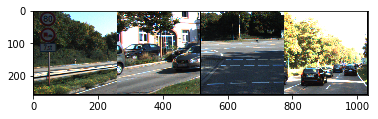

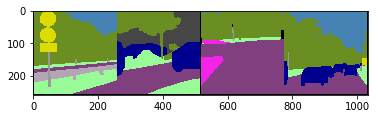

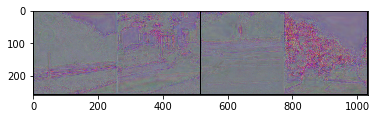

In [49]:
for i_batch, sample_batched in enumerate(train_loader):
    
    
    # Prepare the data
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    
    inputs_float = inputs.type(torch.FloatTensor)
    labels_float = labels.type(torch.FloatTensor)
    
    
    #Analyse the data 
    print("The inputs is: ")
    print(inputs_float)
    
    print('\n The groundtruth label is: ')
    print(labels_float)
   
    #feed the network
    outputs = unet(inputs_float.cuda())
    print("\n The output is: ")
    print(outputs.dtype)
    print(outputs)
    
    print("The image size is: "+ str(inputs_float.size()) + ". The inputs data type is: " + str(inputs_float.dtype))
    print("The groundtruth mask size is :"+ str(labels.size()) + ". The groundtruth mask type is: " + str(labels_float.dtype))
    print("The predicted mask size is :" +str(outputs.size()) + ". The predicted mask type is " + str(outputs.dtype))
    
    
    #Visualisaton
    show_semantic_batch(sample_batched)
    plt.pause(0.5)
    grid = utils.make_grid(outputs)
    plt.imshow(grid.cpu().detach().numpy().transpose((1,2,0)))

    
    if i_batch == 0:
        
        break

### Define a Loss function and optimizer

In [50]:
import torch.optim as optim
mylr = 0.005
criterion = nn.BCELoss()

### Train the network

In [ ]:
for epoch in range(20):
    # loop over the dataset 1 times
    running_loss = 0.0
    if epoch%5==4:
        mylr = mylr/5
    optimizer = optim.SGD(unet.parameters(),
                      lr=mylr,
                      momentum=0.9,
                      weight_decay=0.0005)
    for i_batch, sample_batched in enumerate(train_loader):
        
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['semantic']
        
        inputs_float = inputs.type(torch.FloatTensor)
        labels_float = labels.type(torch.FloatTensor)
        labels_float /= 255
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward +optimize
        outputs = unet(inputs_float.cuda())
        
        outputs_flat = outputs.view(-1)
        labels_flat = labels_float.view(-1)
    
        # Define the loss
        loss = criterion(outputs_flat, labels_flat.cuda())      
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i_batch%20 == 19: 
            # print every 20 mini-batchs
            print('[%d, %5f] loss: %.3f'%(epoch +1, i_batch+1, running_loss/20))
            running_loss = 0.0
print('Finish Training')

[1, 20.000000] loss: 0.661
[1, 40.000000] loss: 0.655
[1, 60.000000] loss: 0.653
[1, 80.000000] loss: 0.648
[1, 100.000000] loss: 0.637
[1, 120.000000] loss: 0.637
[2, 20.000000] loss: 0.632
[2, 40.000000] loss: 0.625
[2, 60.000000] loss: 0.625
[2, 80.000000] loss: 0.633
[2, 100.000000] loss: 0.629
[2, 120.000000] loss: 0.631
[3, 20.000000] loss: 0.632
[3, 40.000000] loss: 0.627
[3, 60.000000] loss: 0.617
[3, 80.000000] loss: 0.625
[3, 100.000000] loss: 0.629
[3, 120.000000] loss: 0.626
[4, 20.000000] loss: 0.619
[4, 40.000000] loss: 0.623
[4, 60.000000] loss: 0.622
[4, 80.000000] loss: 0.617
[4, 100.000000] loss: 0.626
[4, 120.000000] loss: 0.617
[5, 20.000000] loss: 0.621
[5, 40.000000] loss: 0.621
[5, 60.000000] loss: 0.613
[5, 80.000000] loss: 0.619
[5, 100.000000] loss: 0.617
[5, 120.000000] loss: 0.611
[6, 20.000000] loss: 0.615
[6, 40.000000] loss: 0.618
[6, 60.000000] loss: 0.614
[6, 80.000000] loss: 0.614
[6, 100.000000] loss: 0.613
[6, 120.000000] loss: 0.612
[7, 20.000000] l

### Visualization after training

The inputs is: 
tensor([[[[  53.,   45.,   26.,  ...,   52.,   54.,   38.],
          [  48.,   40.,   23.,  ...,   51.,   51.,   36.],
          [  17.,   15.,   19.,  ...,   22.,   18.,   33.],
          ...,
          [  23.,   21.,   21.,  ...,   19.,   18.,   20.],
          [  24.,   24.,   24.,  ...,   20.,   20.,   21.],
          [  24.,   24.,   24.,  ...,   21.,   21.,   21.]],

         [[  43.,   38.,   21.,  ...,   81.,   69.,   45.],
          [  47.,   35.,   20.,  ...,   55.,   37.,   32.],
          [  23.,   23.,   17.,  ...,   27.,   30.,   33.],
          ...,
          [  22.,   23.,   23.,  ...,   26.,   25.,   24.],
          [  24.,   23.,   23.,  ...,   26.,   26.,   24.],
          [  24.,   22.,   22.,  ...,   26.,   26.,   26.]],

         [[  45.,   30.,   20.,  ...,   51.,   44.,   42.],
          [  12.,   15.,   17.,  ...,   26.,   13.,    8.],
          [  16.,   17.,   17.,  ...,   24.,   13.,   11.],
          ...,
          [  29.,   29.,   28.,  ..

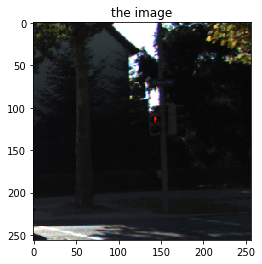

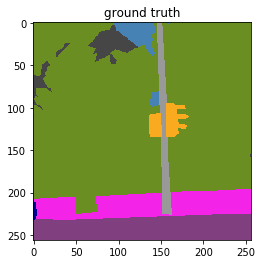

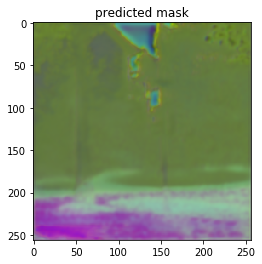

In [40]:
for i_batch, sample_batched in enumerate(train_loader):
    
    
    # Prepare the data
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    
    inputs_float = inputs.type(torch.FloatTensor)
    labels_float = labels.type(torch.FloatTensor)
    
    
    #Analyse the data 
    print("The inputs is: ")
    print(inputs_float)
    
    print('\n The groundtruth label is: ')
    print(labels_float)
   
    #feed the network
    outputs = unet(inputs_float.cuda())
    print("\n The output is: ")
    print(outputs.dtype)
    print(outputs)
    
    print("The image size is: "+ str(inputs_float.size()) + ". The inputs data type is: " + str(inputs_float.dtype))
    print("The groundtruth mask size is :"+ str(labels.size()) + ". The groundtruth mask type is: " + str(labels_float.dtype))
    print("The predicted mask size is :" +str(outputs.size()) + ". The predicted mask type is " + str(outputs.dtype))
    
    
    #Visualisaton
    show_semantic_batch(sample_batched)
    plt.pause(0.5)
    grid = utils.make_grid(outputs)
    plt.imshow(grid.cpu().detach().numpy().transpose((1,2,0)))

    
    if i_batch == 0:
        
        break
    

### cross validation

In [ ]:
# for i_batch, sample_batched in enumerate(validation_loader):